# Solving differential equations with dCGP

Lets first import dcgpy and pyaudi and set up things as to use dCGP on gduals defined over vectorized floats

In [1]:
from dcgpy import expression_gdual_vdouble as expression
from dcgpy import kernel_set_gdual_vdouble as kernel_set
from pyaudi import gdual_vdouble as gdual
from matplotlib import pyplot as plt
import numpy as np
from numpy import sin, cos
from random import randint
np.seterr(all='ignore') # avoids numpy complaining about early on malformed expressions being evalkuated
%matplotlib inline

## The kernel functions

In [125]:
kernels = kernel_set(["sum", "mul", "div", "diff", "log", "sin", "cos", "exp"])() # note the call operator (returns the list of kernels)

## Instantiate a (1 input, 1 output) dCGP and we inspect a randomly created program

In [3]:
dCGP_example = expression(inputs=1, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = 1)

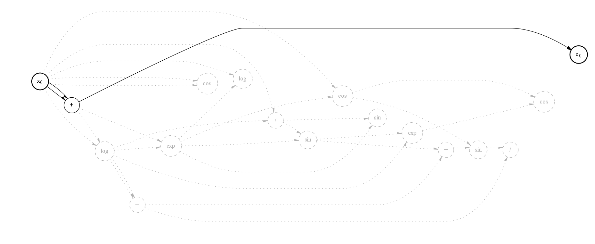

Represented expression:  (x+x)
Simplified expression:  [2*x]


In [4]:
plt.rcParams["figure.figsize"] = [10,6]
dCGP_example.visualize() #requires pygraphwiz module installed
print("Represented expression: ", dCGP_example(["x"])[0])
print("Simplified expression: ", dCGP_example.simplify(["x"])) #requires sympy module installed

## Define the ES that will evolve solutions

In [115]:
# We run an evolutionary strategy ES(1 + offspring)
def run_experiment(max_gen, offsprings, quadratic_error, initial_conditions_error, dCGP, screen_output=False):
    chromosome = [1] * offsprings
    fitness = [1] *offsprings
    best_chromosome = dCGP.get()
    best_fitness = quadratic_error(dCGP, grid) + initial_conditions_error(dCGP)
    for g in range(max_gen):
        for i in range(offsprings):
            dCGP.set(best_chromosome)
            dCGP.mutate_active(i+1) #  we mutate a number of increasingly higher active genes
            qe = quadratic_error(dCGP, grid)
            ie = initial_conditions_error(dCGP)
            fitness[i] = ie + qe
            chromosome[i] = dCGP.get()
        for i in range(offsprings):
            if fitness[i] <= best_fitness:
                if (fitness[i] != best_fitness) and screen_output:
                    print("New best found: gen: ", g, " value: ", fitness[i])
                best_chromosome = chromosome[i]
                best_fitness = fitness[i]
                dCGP.set(best_chromosome)
        if best_fitness < 1e-7:
            break
    return g, best_chromosome

## Consider the following Ordinary Differential Equation (ODE1):

$\frac{dy}{dx} = \frac{2x - y}{x}$, with $y(0.1) = 20.1$ and $x \in [0.1,1]$

we demand its punctual validity over a grid of $N$ equally spaced points.

The solution to the ODE is $y = x + \frac 2x$

In [126]:
# We define the quadratic error of the dCGP in the grid points
def qe_ODE1(dCGP, grid):
    retval = 0
    out = dCGP([grid])[0]
    y = np.array(out.constant_cf)
    dydx = np.array(out.get_derivative({"dx" : 1}))
    x = np.array(grid.constant_cf)
    ode1 = (2. * x - y) / x
    retval += (ode1 - dydx) * (ode1 - dydx)
    return sum(retval)

In [127]:
# We define a penalty term associated to the initial conditions violation
def ic_ODE1(dCGP):
    x0 = 1
    y0 = 3
    out = dCGP([gdual([x0])])[0]
    return (out.constant_cf[0] - y0) * (out.constant_cf[0] - y0)

In [128]:
# We construct the grid of points. Since the ODE only contains first order derivatives we use truncation order 1.
# Since we are using vectorized gdual we can instantiate only one gdual

values = np.linspace(0.1,1,10)
grid = gdual(values, "x", 1)

In [135]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
offsprings = 10
stop = 500
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(inputs=1, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,100000))
    g, best_chromosome = run_experiment(max_gen = stop, offsprings = offsprings, \
            quadratic_error=qe_ODE1, initial_conditions_error=ic_ODE1, dCGP = dCGP)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x"]), " a.k.a ", dCGP.simplify(["x"]))
res = np.array(res)

restart: 	 gen: 	 expression:
0 		 194 	 ['(x+((x+x)/(x*x)))']  a.k.a  [x + 2/x]
1 		 44 	 ['(x+(((x/x)/x)*(((x/x)+(x/x))*(x/x))))']  a.k.a  [x + 2/x]
4 		 483 	 ['((x/(x/x))+(((x/x)/x)+((x/x)/x)))']  a.k.a  [x + 2/x]
6 		 423 	 ['(x+(((x/x)+(x/x))/x))']  a.k.a  [x + 2/x]
13 		 292 	 ['(((x/x)/x)+(x+((x/x)/x)))']  a.k.a  [x + 2/x]
14 		 248 	 ['(sin((x-x))+(((exp((x-x))+((x-x)+exp(sin((x-x)))))/x)+(x+(x-x))))']  a.k.a  [x + 2/x]
19 		 456 	 ['((x+(x/(x*x)))+(x/(x*x)))']  a.k.a  [x + 2/x]
21 		 321 	 ['(((x+x)-x)+((x+x)/(((x+x)-x)*((x+x)-x))))']  a.k.a  [x + 2/x]
26 		 348 	 ['(((x/x)/x)+(x+((x/x)/x)))']  a.k.a  [x + 2/x]
27 		 149 	 ['(x+(((x+x)+(x+x))/((x+x)*x)))']  a.k.a  [x + 2/x]
29 		 205 	 ['((((x/x)/x)+((x/x)/x))+x)']  a.k.a  [x + 2/x]
32 		 223 	 ['((((x/x)+(x/x))/((x/x)*x))+log(exp(x)))']  a.k.a  [x + 2/x]
34 		 142 	 ['(x+(((x/x)+(x/x))/x))']  a.k.a  [x + 2/x]
35 		 426 	 ['(x+(((x+x)/x)/x))']  a.k.a  [x + 2/x]
36 		 371 	 ['(x+((x+x)/(x*x)))']  a.k.a  [x + 2/x]
37 		 344 	 [

In [136]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 653 * 200)

ERT Expected run time - avg. number of function evaluations needed:  8977.27272727
Avg. number of function evaluations from Tsoulos paper:  130600


## Consider the following Ordinary Differential Equation (ODE2):

$\frac{dy}{dx} = \frac{1 - ycos(x)}{sin(x)}$, with $y(0.1) = \frac{2.1}{sin(0,1)}$ and $x \in [0.1,1]$

we demand its punctual validity over a grid of $N$ equally spaced points.

NOTE: The solution to the ODE is $y = \frac{x+2}{sin(x)}$

In [137]:
# We construct the grid of points. Since the ODE only contains first order derivatives we use truncation order 1.
# Since we are using vectorized gdual we can instantiate only one gdual

values = np.linspace(0.1,1,10)
grid = gdual(values, "x", 1)

In [138]:
# We define the quadratic error of the dCGP in the grid points
def qe_ODE2(dCGP, grid):
    retval = 0
    out = dCGP([grid])[0]
    y = np.array(out.constant_cf)
    dydx = np.array(out.get_derivative({"dx" : 1}))
    x = np.array(grid.constant_cf)
    ode2 = (1. -  y * cos(x)) / sin(x)
    retval += (ode2 - dydx) * (ode2 - dydx)
    return sum(retval)

In [139]:
# We define a penalty term associated to the initial conditions violation
dummy = (2.1)/sin(0.1)
def ic_ODE2(dCGP):
    x0 = 0.1
    y0 = dummy
    out = dCGP([gdual([x0])])[0]
    return (out.constant_cf[0] - y0) * (out.constant_cf[0] - y0)

In [140]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
stop = 500
offsprings = 10
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(inputs=1, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,100000))
    g, best_chromosome = run_experiment(max_gen = stop, offsprings = offsprings, \
            quadratic_error=qe_ODE2, initial_conditions_error=ic_ODE2, dCGP=dCGP)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x"]), " a.k.a ", dCGP.simplify(["x"]))
res = np.array(res)

restart: 	 gen: 	 expression:
18 		 269 	 ['((((x/sin(x))+(x/sin(x)))/(sin(x)*(x/sin(x))))+(x/sin(x)))']  a.k.a  [x/sin(x) + 2/sin(x)]
30 		 33 	 ['(((x/x)+((x/x)+x))/((x/x)*sin(x)))']  a.k.a  [x/sin(x) + 2/sin(x)]
33 		 61 	 ['((((x+x)/sin(x))/x)+(((x+x)/sin(x))/((x+x)/x)))']  a.k.a  [x/sin(x) + 2/sin(x)]
41 		 456 	 ['((((x/sin(x))/x)+((x/sin(x))/x))+(x/sin(x)))']  a.k.a  [x/sin(x) + 2/sin(x)]
48 		 328 	 ['((((x+(sin(x)/sin(x)))*((x+(sin(x)/sin(x)))/(x+(sin(x)/sin(x)))))+((x+(sin(x)/sin(x)))/(x+(sin(x)/sin(x)))))/sin(x))']  a.k.a  [x/sin(x) + 2/sin(x)]
59 		 127 	 ['((((x/x)*(x/x))+((x/x)+x))/sin(x))']  a.k.a  [x/sin(x) + 2/sin(x)]
60 		 124 	 ['(((x/x)+((x/x)+x))/sin(x))']  a.k.a  [x/sin(x) + 2/sin(x)]
62 		 191 	 ['((((x/x)+x)+(x/x))/sin(x))']  a.k.a  [x/sin(x) + 2/sin(x)]
71 		 8 	 ['(((x+(x/x))+(x/x))/sin(x))']  a.k.a  [x/sin(x) + 2/sin(x)]
76 		 37 	 ['((((x/x)+x)+(x/x))/sin(x))']  a.k.a  [x/sin(x) + 2/sin(x)]
90 		 351 	 ['(((x/sin(x))+((x/sin(x))/x))+((x/sin(x))/x))']  a.k.a 

In [141]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 742 * 200)

ERT Expected run time - avg. number of function evaluations needed:  35482.3076923
Avg. number of function evaluations from Tsoulos paper:  148400


## Consider the following Ordinary Differential Equation (ODE5):

$\frac{d^2y}{dx^2} = 6\frac{dy}{dx} - 9y$, with $y(0) = 0$, $\frac{dy}{dx}(0)=2$ and $x \in [0,1]$

we demand its punctual validity over a grid of $N$ equally spaced points.

NOTE: The solution to the ODE is $y = 2x \exp(3x)$

In [142]:
# We construct the grid of points. Since the ODE only contains second order derivatives we use truncation order 2.
# Since we are using vectorized gdual we can instantiate only one gdual

values = np.linspace(0,1,10)
grid = gdual(values, "x", 2)

In [143]:
# We define the quadratic error of the dCGP in the grid points
def qe_ODE5(dCGP, grid):
    retval = 0
    out = dCGP([grid])[0]
    y = np.array(out.constant_cf)
    dydx = np.array(out.get_derivative({"dx" : 1}))
    dydx2 = np.array(out.get_derivative({"dx" : 2}))
    x = np.array(grid.constant_cf)
    ode5 = 6. * dydx - 9 * y
    retval += (ode5 - dydx2) * (ode5 - dydx2)
    return sum(retval)

In [144]:
# We define a penalty term associated to the initial conditions violation
def ic_ODE5(dCGP):
    x0 = 1e-16 # avoids what seems a numerical problem with vectorized dual?
    y0 = 0.
    dy0 = 2.
    out = dCGP([gdual([x0], "x", 1)])[0]
    dCGP_y0 = out.constant_cf[0]
    dCGP_dy0 = out.get_derivative({"dx" : 1})[0]
    return (dCGP_y0 - y0) * (dCGP_y0 - y0) + (dCGP_dy0 - dy0) * (dCGP_dy0 - dy0)

In [145]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
stop = 500
offsprings = 10
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(inputs=1, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,100000))
    g, best_chromosome = run_experiment(max_gen = stop, offsprings = offsprings, \
            quadratic_error=qe_ODE5, initial_conditions_error=ic_ODE5, dCGP=dCGP)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x"]), " a.k.a ", dCGP.simplify(["x"]))
res = np.array(res)

restart: 	 gen: 	 expression:
8 		 220 	 ['(((exp(x)*exp(x))*exp(x))*log((exp(x)*exp(x))))']  a.k.a  [2*x*exp(3*x)]
12 		 301 	 ['(((x*exp(x))*exp(x))*(exp(x)+exp(x)))']  a.k.a  [2*x*exp(3*x)]
16 		 191 	 ['((x+x)*exp((x+(x+x))))']  a.k.a  [2*x*exp(3*x)]
31 		 253 	 ['(log((exp(x)*exp(x)))*((exp(x)*exp(x))*exp(x)))']  a.k.a  [2*x*exp(3*x)]
32 		 359 	 ['((x+x)*exp((x+(x+x))))']  a.k.a  [2*x*exp(3*x)]
37 		 173 	 ['(((exp(x)*x)*(exp(x)*exp(x)))+((exp(x)*x)*(exp(x)*exp(x))))']  a.k.a  [2*x*exp(3*x)]
48 		 216 	 ['((exp(x)*exp(x))*(exp(x)*(x+x)))']  a.k.a  [2*x*exp(3*x)]
50 		 444 	 ['(((x+x)*exp((x+x)))*exp(x))']  a.k.a  [2*x*exp(3*x)]
52 		 473 	 ['((x+x)*exp(((x+x)+x)))']  a.k.a  [2*x*exp(3*x)]
64 		 179 	 ['(exp(x)*((exp(x)*(exp(x)+exp(x)))*x))']  a.k.a  [2*x*exp(3*x)]
65 		 52 	 ['((x+x)*exp(((x+x)+x)))']  a.k.a  [2*x*exp(3*x)]
68 		 193 	 ['((x+x)*log(exp(exp((x+(x+x))))))']  a.k.a  [2*x*exp(3*x)]
71 		 291 	 ['((x+x)*exp((((x+x)-x)+(x+x))))']  a.k.a  [2*x*exp(3*x)]
72 		 468 	 ['((

In [146]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 441 * 200)

ERT Expected run time - avg. number of function evaluations needed:  22610.5
Avg. number of function evaluations from Tsoulos paper:  88200


## Consider the following non linear Ordinary Differential Equation (NLODE3):

$\frac{d^2y}{dx^2}\frac{dy}{dx} = -\frac4{x^3}$, with $y(1) = 0$, and $x \in [1,2]$

we demand its punctual validity over a grid of $N$ equally spaced points.

NOTE: The solution to the ODE is $y = log(x^2)$

In [147]:
# We construct the grid of points. Since the ODE only contains second order derivatives we use truncation order 2.
# Since we are using vectorized gdual we can instantiate only one gdual

values = np.linspace(1,2,10)
grid = gdual(values, "x", 2)

In [148]:
# We define the quadratic error of the dCGP in the grid points
def qe_NLODE3(dCGP, grid):
    retval = 0
    out = dCGP([grid])[0]
    y = np.array(out.constant_cf)
    dydx = np.array(out.get_derivative({"dx" : 1}))
    dydx2 = np.array(out.get_derivative({"dx" : 2}))
    x = np.array(grid.constant_cf)
    nlode3 = dydx2*dydx
    retval += (nlode3 + 4/x/x/x) * (nlode3 + 4/x/x/x)
    return sum(retval)

In [149]:
# We define a penalty term associated to the initial conditions violation
def ic_NLODE3(dCGP):
    x0 = 1.
    y0 = 0.
    out = dCGP([gdual([x0])])[0]
    dCGP_y0 = out.constant_cf[0]
    dCGP_dy0 = out.get_derivative({"dx" : 1})[0]
    return (dCGP_y0 - y0) * (dCGP_y0 - y0)

In [150]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
stop = 500
offsprings = 10
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(inputs=1, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,100000))
    g, best_chromosome = run_experiment(max_gen = stop, offsprings = offsprings, \
            quadratic_error=qe_NLODE3, initial_conditions_error=ic_NLODE3, dCGP=dCGP)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x"]), " a.k.a ", dCGP.simplify(["x"]))
res = np.array(res)

restart: 	 gen: 	 expression:
0 		 13 	 ['log((x*x))']  a.k.a  [log(x**2)]
2 		 4 	 ['log((x*x))']  a.k.a  [log(x**2)]
3 		 8 	 ['log((x*x))']  a.k.a  [log(x**2)]
4 		 21 	 ['log((x*x))']  a.k.a  [log(x**2)]
5 		 39 	 ['(log(x)+log(x))']  a.k.a  [2*log(x)]
6 		 138 	 ['log((x*x))']  a.k.a  [log(x**2)]
7 		 0 	 ['log(((x*x)-log((x/x))))']  a.k.a  [log(x**2)]
9 		 10 	 ['log((x*x))']  a.k.a  [log(x**2)]
10 		 5 	 ['log((x*x))']  a.k.a  [log(x**2)]
11 		 9 	 ['(log(x)+log(x))']  a.k.a  [2*log(x)]
12 		 50 	 ['(log(x)+log(x))']  a.k.a  [2*log(x)]
13 		 15 	 ['log((x*x))']  a.k.a  [log(x**2)]
14 		 11 	 ['((log(x)+log(x))+(x-x))']  a.k.a  [2*log(x)]
16 		 80 	 ['log((x*x))']  a.k.a  [log(x**2)]
17 		 2 	 ['(log(x)+log(x))']  a.k.a  [2*log(x)]
18 		 47 	 ['(log(x)+log(x))']  a.k.a  [2*log(x)]
19 		 1 	 ['(log(sin(x))-log(((x*sin(x))*x)))']  a.k.a  [-log(x**2*sin(x)) + log(sin(x))]
21 		 7 	 ['log((x*x))']  a.k.a  [log(x**2)]
24 		 17 	 ['log((x*x))']  a.k.a  [log(x**2)]
26 		 39 	 ['log((x*x

In [151]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected run time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 191 * 200)

ERT Expected run time - avg. number of function evaluations needed:  896.666666667
Avg. number of function evaluations from Tsoulos paper:  38200


## Consider the following non linear Patial Differential Equation (PDE2):

$\nabla^2 \psi(x,y) = -\psi(x,y)$ with $x\in[0,1]$, $y\in[0,1]$ and boundary conditions: $\psi(0,y) = 0$, $\psi(1,y) = \sin(1)\cos(y)$

we demand its punctual validity over a squared grid of $N$ equally spaced points.

NOTE: The solution to the PDE is $\psi(x,y) = \sin(x)\cos(y)$

In [152]:
# We construct the grid of points. Since the PDE only contains second order derivatives we use truncation order 2.
# Since we are using vectorized gdual we can instantiate only one gdual
N=10
values = np.linspace(0,1,N)
xval = np.append(values,[values]*(N-1))
yval = values.repeat(N)
grid = [gdual(xval, "x", 2), gdual(yval, "y", 2)]

In [153]:
# We define the quadratic error of the dCGP in the grid points
def qe_PDE1(dCGP, grid):
    retval = 0
    out = dCGP([grid[0], grid[1]])[0]
    psi = np.array(out.constant_cf)
    dpsidx2 = np.array(out.get_derivative({"dx" : 2}))
    dpsidy2 = np.array(out.get_derivative({"dy" : 2}))
    x = np.array(grid[0].constant_cf)
    y = np.array(grid[1].constant_cf)  
    pde1 = -2 * psi
    retval += (pde1 - dpsidx2 - dpsidy2) * (pde1 - dpsidx2 - dpsidy2)
    return sum(retval)

In [154]:
# We define a penalty term associated to the initial conditions violation
sin1 = np.sin(1)
def ic_PDE1(dCGP):
    x0 = gdual([0]*N)
    y0 = gdual(values)
    psi = dCGP([x0, y0])[0]
    dCGP_psi = np.array(psi.constant_cf)
    err1 = (dCGP_psi - 0.) * (dCGP_psi - 0.)
    x0 = gdual([1]*N)
    y0 = gdual(values)
    psi = dCGP([x0, y0])[0]
    dCGP_psi = psi.constant_cf
    err2 = (dCGP_psi - sin1*np.cos(values)) * (dCGP_psi - sin1*np.cos(values))
    return sum(err1) + sum(err2)

In [155]:
# We run nexp experiments to accumulate statistic for the ERT
nexp = 100
stop = 500
offsprings = 10
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(inputs=2, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,100000))
    g, best_chromosome = run_experiment(max_gen = stop, offsprings = offsprings, \
            quadratic_error=qe_PDE1, initial_conditions_error=ic_PDE1, screen_output=False, dCGP=dCGP)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x","y"]), " a.k.a ", dCGP.simplify(["x","y"]))
res = np.array(res)

restart: 	 gen: 	 expression:
1 		 291 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
7 		 410 	 ['(cos(y)*sin(x))']  a.k.a  [sin(x)*cos(y)]
9 		 487 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
16 		 254 	 ['(cos(y)*sin(x))']  a.k.a  [sin(x)*cos(y)]
20 		 203 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
30 		 81 	 ['(cos(y)*sin(x))']  a.k.a  [sin(x)*cos(y)]
32 		 409 	 ['(cos(y)*sin(x))']  a.k.a  [sin(x)*cos(y)]
35 		 472 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
46 		 270 	 ['(cos(y)*sin(x))']  a.k.a  [sin(x)*cos(y)]
49 		 375 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
51 		 245 	 ['(cos(y)*sin(x))']  a.k.a  [sin(x)*cos(y)]
55 		 201 	 ['(cos(y)*sin(x))']  a.k.a  [sin(x)*cos(y)]
62 		 53 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
70 		 363 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
71 		 481 	 ['(cos(y)*sin(x))']  a.k.a  [sin(x)*cos(y)]
78 		 34 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
87 		 288 	 ['(sin(x)*cos(y))']  a.k.a  [sin(x)*cos(y)]
93 		 377 	 ['(cos(((y-y

In [156]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected Run Time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 203 * 200)

ERT Expected Run Time - avg. number of function evaluations needed:  24192.1052632
Avg. number of function evaluations from Tsoulos paper:  40600


## Consider the following non linear Patial Differential Equation (PDE6):

$\nabla^2 \psi(x,y) + \exp(\psi(x,y)) = 1 + x^2 + y^2 + \frac 4{(1 + x^2 + y^2)^2}$ with $x\in[0.1,3]$, $y\in[0.1,3]$ and boundary conditions: $\psi(0,y) = \log(1+y^2)$, $\psi(1,y) = \log(2+y^2)$

we demand its punctual validity over a squared grid of $N$ equally spaced points.

NOTE: The solution to the PDE is $\psi(x,y) = \log(1 + x^2 + y^2)$

In [171]:
# We construct the grid of points. Since the PDE only contains second order derivatives we use truncation order 2.
# Since we are using vectorized gdual we can instantiate only one gdual
N=10
values = np.linspace(0.1,3,N)
xval = np.append(values,[values]*(N-1))
yval = values.repeat(N)
grid = [gdual(xval, "x", 2), gdual(yval, "y", 2)]

In [172]:
# We define the quadratic error of the dCGP in the grid points
def qe_PDE6(dCGP, grid):
    retval = 0
    out = dCGP([grid[0], grid[1]])[0]
    psi = np.array(out.constant_cf)
    dpsidx2 = np.array(out.get_derivative({"dx" : 2}))
    dpsidy2 = np.array(out.get_derivative({"dy" : 2}))
    x = np.array(grid[0].constant_cf)
    y = np.array(grid[1].constant_cf)  
    pde6 = 4./(1+x*x+y*y)**2
    retval += (pde6 - dpsidx2 - dpsidy2) * (pde6 - dpsidx2 - dpsidy2)
    return sum(retval) / N**2

In [190]:
### We define a penalty term associated to the initial conditions violation
def ic_PDE6(dCGP):
    x0 = gdual([0.1]*N)
    y0 = gdual(values)
    psi = dCGP([x0, y0])[0]
    dCGP_psi = np.array(psi.constant_cf)
    err1 = (dCGP_psi - np.log(1+values*values+0.01)) * (dCGP_psi - np.log(1+values*values+0.01))
    x0 = gdual([3]*N)
    y0 = gdual(values)
    psi = dCGP([x0, y0])[0]
    dCGP_psi = psi.constant_cf
    err2 = (dCGP_psi - np.log(10+values*values)) * (dCGP_psi - np.log(10+values*values))
    x0 = gdual(values)
    y0 = gdual([0.1]*N)
    psi = dCGP([x0, y0])[0]
    dCGP_psi = np.array(psi.constant_cf)
    err3 = (dCGP_psi - np.log(1+values*values+0.01)) * (dCGP_psi - np.log(1+values*values+0.01))
    x0 = gdual(values)
    y0 = gdual([3]*N)
    psi = dCGP([x0, y0])[0]
    dCGP_psi = psi.constant_cf
    err4 = (dCGP_psi - np.log(10+values*values)) * (dCGP_psi - np.log(10+values*values))
    return (sum(err1) + sum(err2) + sum(err4) + sum(err3)) 

In [191]:
# We run nexp experiments to accumulate statistic for the ERT
kernels = kernel_set(["sum", "mul", "div", "diff", "log","exp","cos","sin"])() # note the call operator (returns the list of kernels)
nexp = 100
stop = 2000
offsprings = 10
res = []
print("restart: \t gen: \t expression:")
for i in range(nexp):
    dCGP = expression(inputs=2, outputs=1, rows=1, cols=15, levels_back=16, arity=2, kernels=kernels, seed = randint(0,100000))
    g, best_chromosome = run_experiment(max_gen = stop, offsprings = offsprings, \
            quadratic_error=qe_PDE6, initial_conditions_error=ic_PDE6, screen_output=False, dCGP=dCGP)
    res.append(g)
    dCGP.set(best_chromosome)
    if g < (stop-1):
        print(i, "\t\t", res[i], "\t", dCGP(["x","y"]), " a.k.a ", dCGP.simplify(["x","y"]), " ", qe_PDE6(dCGP,grid)+ic_PDE6(dCGP))
res = np.array(res)

restart: 	 gen: 	 expression:
13 		 1586 	 ['log(((x*x)+((y*y)+((y*y)/(y*y)))))']  a.k.a  [log(x**2 + y**2 + 1)]   2.05547700971e-28
36 		 1225 	 ['log((((x*x)+(y/y))+(y*y)))']  a.k.a  [log(x**2 + y**2 + 1)]   7.18298744104e-32
47 		 511 	 ['log((((((x*x)/(x*x))*(y*y))+((x*x)/(x*x)))+(x*x)))']  a.k.a  [log(x**2 + y**2 + 1)]   7.90590617962e-28
48 		 1917 	 ['log((((x/x)+(x*x))+(y*y)))']  a.k.a  [log(x**2 + y**2 + 1)]   7.21996529597e-32
77 		 1230 	 ['log((((y/y)+(y*y))+(x*x)))']  a.k.a  [log(x**2 + y**2 + 1)]   7.17836520917e-32
93 		 1837 	 ['log((((y*y)+(y/y))+(x*x)))']  a.k.a  [log(x**2 + y**2 + 1)]   7.17836520917e-32


In [192]:
ERT = sum(res) / sum(res<(stop-1))
print("ERT Expected Run Time - avg. number of function evaluations needed: ", ERT * offsprings)
print("Avg. number of function evaluations from Tsoulos paper: ", 797 * 1000) # here we assume tsoulos used the maximum population size since PDE6 is the most difficult problem

ERT Expected Run Time - avg. number of function evaluations needed:  327020.0
Avg. number of function evaluations from Tsoulos paper:  797000
